# High-Quality Data Augmentation for Low-Resource NMT: Combining Translation Memory, a GAN Generator, and Filtering


#### As this is a proof-of-concept demonstration:
1. We employ toy data instead of real datasets.

2. The translation outputs are primarily intended to illustrate the viability of our approach.

In [1]:
!pip install -r requirements.txt

## Integrating Translation Memory into Input: 
Translation Memory (TM) is an effective approach to enhance machine translation by providing additional training data for the model.

Consequently, we integrated TM into the model's input.



<img src="./figure/TM.png" width="40%" style="margin: 0 auto;">

We employ the retrieval method to find sentences $s_t$ in the TM that are semantically similar to the source input $s$, along with their corresponding target sentences $t_t$. 
Here, we introduce a threshold for the Euclidean distance between sentence vectors to ensure the quality of the retrieved TM. 
Additionally, considering the limited number of sentences in the low-resource language TM, we avoid setting this threshold too high or too low. 
In subsequent experiments, the threshold is set to 0.5.
- $s$: A German sentence on source side.
- $s_{t}$: A German sentence on source side which is similar to $s$.
- $t_{t}$: A Upper Sorbian senctence on target side corresponding to $s_{t}$.

In [2]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

from retrieval.similar_sentences_selection import read_data, generate_new, similar_domain_selection

experiments= "GAN_TM"
# original bilingual corpus training: 50 * 2, validation: 5 * 2, test: 5 * 2
de = './data/toy_data/train.hsb-de.de'
hsb = './data/toy_data/train.hsb-de.hsb'
val_de = './data/toy_data/devel.hsb-de.de'
val_hsb = './data/toy_data/devel.hsb-de.hsb'
test_de = './data/toy_data/devel_test.hsb-de.de'
test_hsb = './data/toy_data/devel_test.hsb-de.hsb'
# target path to write new sentence pair integrated with TM.
train_src = './data/{}/train.dehsb_hsb.dehsb'.format(experiments)
train_tgt = './data/{}/train.dehsb_hsb.hsb'.format(experiments)
val_src = './data/{}/val.dehsb_hsb.dehsb'.format(experiments)
val_tgt = './data/{}/val.dehsb_hsb.hsb'.format(experiments)
test_src = './data/{}/test.dehsb_hsb.dehsb'.format(experiments)
test_tgt = './data/{}/test.dehsb_hsb.hsb'.format(experiments)
# separations
S = "[SEP]"
St = "[SEP]"
Tt = "[SEP]"

de_lines = read_data(de)
hsb_lines = read_data(hsb)
val_de_lines = read_data(val_de)
val_hsb_lines = read_data(val_hsb)
test_de_lines = read_data(test_de)
test_hsb_lines = read_data(test_hsb)

generate_new(top_k_similar=10, distance=0.5, retrieve_dataset=de_lines, query_lines=de_lines, retrieve_tar_sen_dataset=hsb_lines, query_tar_sen_dataset=hsb_lines, new_src_path=train_src, new_tgt_path=train_tgt)
generate_new(top_k_similar=10, distance=0.5, retrieve_dataset=de_lines, query_lines=val_de_lines, retrieve_tar_sen_dataset=hsb_lines, query_tar_sen_dataset=val_hsb_lines, new_src_path=val_src, new_tgt_path=val_tgt)
generate_new(top_k_similar=2, distance=0.5, retrieve_dataset=de_lines, query_lines=test_de_lines, retrieve_tar_sen_dataset=hsb_lines, query_tar_sen_dataset=test_hsb_lines,  new_src_path=test_src, new_tgt_path=test_tgt)


/home/Liu_Hengjie/miniconda3/envs/test/lib/python3.8/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 2182.65it/s]


the nuber of new generate sentence pairs:  50


100%|█████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 23940.09it/s]


the nuber of new generate sentence pairs:  5


100%|█████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 42111.49it/s]

the nuber of new generate sentence pairs:  5


In [3]:
# similar domain selection
mono_de = "./data/toy_data/news.2007.de.shuffled.deduped"
created_src = './data/{}/created.dehsb_hsb.dehsb'.format(experiments)
mono_src = './data/aug_double/mono.de_hsb.de'
mono_de_lines = read_data(mono_de)
similar_domain_selection(2, mono_de_lines, de_lines, hsb_lines, created_src, mono_src)


100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 165521.07it/s]

the nuber of sentences in monolingual corpus after similar domain selection:  50


In [4]:
# we list the newly generated test set as an example
new_test_de_lines = read_data(test_src)
new_test_hsb_lines = read_data(test_tgt)

for s,t in zip(new_test_de_lines[:-1],new_test_hsb_lines[:-1]):
    print("source sentences: ", s, "\n")
    print("target sentence: ", t, "\n")
    print("-------------------------------------------------------------------------------------------------------------------------------------------\n")

source sentences:   [SEP] Verweise im theoretischen Teil auf das Arbeitsmaterial und umgekehrt erleichtern die konkrete Arbeit an den Texten. [SEP] Gern möchten wir die Arbeit mit Ihnen weiter vertiefen. [SEP] Rady chcemy dźěło z Wami dale pohłubšić. 

target sentence:  Wotkazy z teoretiskeho dźěla na dźěłowy material a nawopak wolóžuja konkretne dźěło na tekstach. 

-------------------------------------------------------------------------------------------------------------------------------------------

source sentences:   [SEP] Die CDU steht dafür, dass dieses Miteinander den Leitgedanken bei allen Entscheidungen bildet. [SEP] Die Mühlroser wissen, wovon ich rede. [SEP] Miłoraženjo wědźa, wo čim rěču. 

target sentence:  CDU steji za to, zo twori tuta zhromadnosć wodźacu mysl při wšitkich rozsudach. 

-------------------------------------------------------------------------------------------------------------------------------------------

source sentences:   [SEP] Die Mitglieder de

## Leveraging A GAN Generator to Implement Back Translation from the Source Side

The GAN structure enables the utilization of additional source-side monolingual corpus to improve the performance of the translation model.

<img src="./figure/GAN.png" width="40%" style="margin: 0 auto;">


We use a vanilla Transformer as a generator, $G$, for complex translation tasks, to generate synthetic data in the target language, i.e., the low-resource language in our settings. 

To build this generator $G$, we design a fusion neural network as a discriminator $D$, composed of parallel BiLSTM and CNN, handling a binary classification task.

$D$ and $G$ play the following two-player minimax game with value function $V(G, D)$:

\begin{equation}
	\begin{split}
		\underset{G}{\min}~\underset{D}{\max}~V(D, G)= \mathbb{E}_{(x, y) \sim P_{data}(x, y)}[\log D(x, y)] \\
	   +~\mathbb{E}_{(x_{1}, y_{1}^{\prime}) \sim P_{G}(x, y)}[\log (1-D(x, y^{\prime}))]
	\end{split}
\end{equation}


In [5]:
# we begin to train the generator in the architecture above.

import train_GAN
train_GAN.begin_training()

# In the train log below, we first print some important parameters.
# In our actual experiments, we leverage early stop and save the best model to ensure the performance.
# Followed with them, is the structure of G and D.

Please modify the model_config.py file if you use our code.
The parameters and path set here are just for toy data.
---------------file path------------------
experiment: GAN_TM
source language: dehsb
target language: hsb
save model folder: ./model/GAN_TM/
save result folder:./result/GAN_TM/
---------------Parameters-----------------
batch_size: 1
the number of epochs: 1
learning rate: 0.000125
dropout: 0.15

Using device: cuda
Device name: NVIDIA RTX A4500
Device memory: 19.71240234375 GB
Max length of source sentence: 117
Max length of target sentence: 50
Max length of source sentence: 67
Max length of target sentence: 28
Max length of source sentence: 67
Max length of target sentence: 28
No model to preload, starting from scratch
DiscriminatorFusion(
  (convs): Conv2d(1, 256, kernel_size=(16, 1), stride=(1, 1))
  (lstm): LSTM(1, 256, num_layers=2, batch_first=True, dropout=0.1, bidirectional=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (CNN_fc): Linear(in_features=256, out_fea

100%|██████████████████████████████████████████████████████████| 50/50 [01:19<00:00,  1.58s/it]


Max length of source sentence: 132
Max length of target sentence: 153


D training process:


Processing Epoch 01: 0it [00:00, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Processing Epoch 01: 49it [00:14, 12.88it/s, d_loss=100.000, d_lr=1.1180339242855553e-05]



save D model:


Processing Epoch 01: 50it [00:17,  2.91it/s, d_loss=100.000, d_lr=1.1180339242855553e-05]




G training process:


Processing Epoch 01:  96%|██████████████████████ | 48/50 [00:05<00:00,  8.58it/s, g_loss=7.857]



validate G model:



Processing Epoch 01: 100%|███████████████████████| 50/50 [01:05<00:00,  1.30s/it, g_loss=7.857]


In [6]:
# translate and evaluate the test set
import translate
translate.main(test=True)

Using device: cuda
Max length of source sentence: 76
Max length of target sentence: 23


100%|████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 61.16it/s]


In [7]:
import evaluation
from tabulate import tabulate
table_header = ['Generator', 'BLEU', 'chrF2', 'TER']
bleu, chrF2, ter = evaluation.cal_bleu()
print(tabulate(tabular_data=[('+TM +GAN', bleu, chrF2, ter)],headers=table_header,tablefmt='grid'))
# evaluation.main()


+-------------+--------+---------+-------+
| Generator   |   BLEU |   chrF2 |   TER |
+=============+========+=========+=======+
| +TM +GAN    |      0 |       0 |   100 |
+-------------+--------+---------+-------+


## Conducting Data Augmentation experiments to Evaluate the Performance of High-quality Filter.

Not all sentences translated by the generator are of high quality. 

Therefore, we implemented the following process to filter out sentences that significantly deviate from natural language sentences. 

We retained high-quality translation results and demonstrated their effectiveness through data augmentation experiments.

<img src="./figure/filter.png" width="40%" style="margin: 0 auto;">


To demonstrate the effectiveness of the low-resource sentences translated by our generator, we utilize data augmentation experiments for verification. 

However, in a standard data augmentation process, the synthetic sentences may vary in quality, and we cannot ensure that all sentences in the synthetic corpus are of high quality. 

Based on this, this thesis proposes an effective high-quality filtering process, as illustrated in Figure.

In [8]:
# translate the monolingual corpus in similar domain
# We use a pretrain model to translate the monolingual corpus, to show the true situation of our filter below.
# In your case, you should use the generator (G) trained above.
# Please modify the model_config.py file.
import translate
translate.main(test=False)

Using device: cuda
Max length of source sentence: 132
Max length of target sentence: 50


100%|██████████████████████████████████████████████████████████| 50/50 [00:23<00:00,  2.11it/s]


In [9]:
!cp ./result/GAN_TM/translation.txt ./data/aug_double/created.de_hsb.hsb
!cp ./data/toy_data/train.hsb-de.de ./data/aug_double/train.de_hsb.de
!cp ./data/toy_data/train.hsb-de.hsb ./data/aug_double/train.de_hsb.hsb

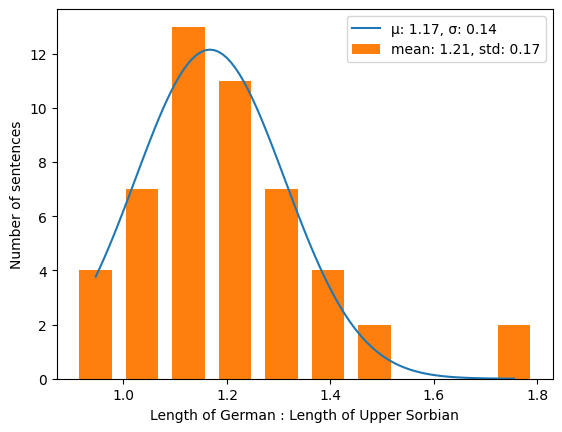

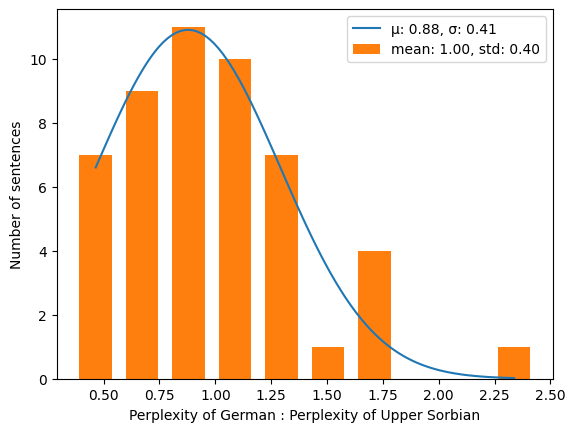

In [10]:
# get the filter interval in natural bilingual corpus
import high_quality_procedure.high_quality_filter as filter
ppl_mean, ppl_std, len_mean, len_std = filter.get_original_interval()

Function filter.filter_synthetic() below accepts four parameters to establish criteria for the filter. 

To conduct comparative experiments, adjust the standard intervals in filter.filter_synthetic() while keeping other procedures unchanged. 

For example:

- filter.filter_synthetic(0, 100, len_mean+len_std, len_mean-len_std) means filter the synthetic sentences by the ratio of length.

This process is straightforward and repetitive, utilizing vanilla Transformer models throughout. 

Therefore, further elaboration is unnecessary.

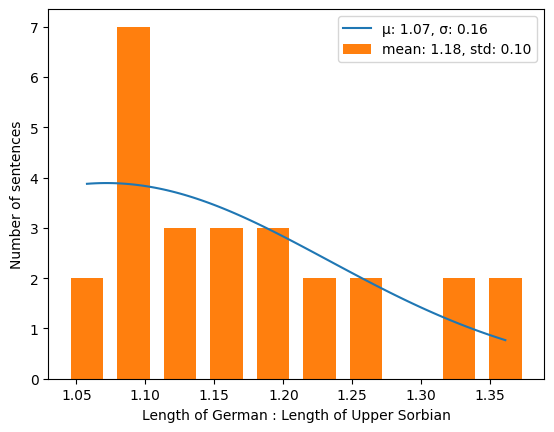

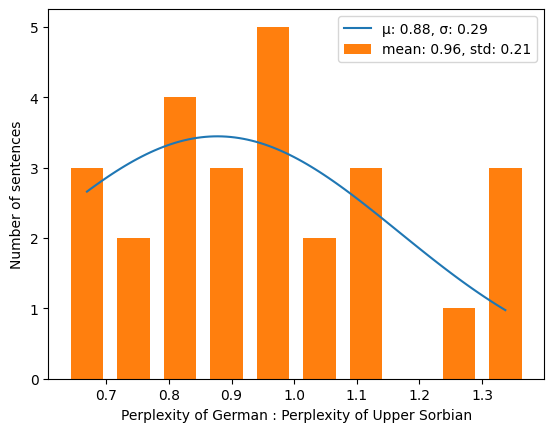

In [11]:
# filter the synthetic bilingual corpus
filter.filter_synthetic(ppl_mean+ppl_std, ppl_mean-ppl_std, len_mean+len_std, len_mean-len_std)

In [12]:
# augment the original bilingual corpus.
!cat ./data/toy_data/train.hsb-de.de ./data/aug_double/filtered.de_hsb.de > ./data/aug_double/train.de_hsb.de

In [13]:
!cat ./data/toy_data/train.hsb-de.hsb ./data/aug_double/filtered.de_hsb.hsb > ./data/aug_double/train.de_hsb.hsb

In [14]:
# data augmentation experiment.
import transformer
transformer.begin_training()


Please modify the model_config.py file if you use our code.
The parameters and path set here are just for toy data.
---------------file path------------------
experiment: aug_double
source language: de
target language: hsb
save model folder: ./model/aug_double/
save result folder:./result/aug_double/
---------------Parameters-----------------
batch_size: 1
the number of epochs:1
learning rate: 0.000125
dropout: 0.15

Using device: cuda
Device name: NVIDIA RTX A4500
Device memory: 19.71240234375 GB
Max length of source sentence: 49
Max length of target sentence: 50
Max length of source sentence: 36
Max length of target sentence: 28
No model to preload, starting from scratch


epoch 1 training process:


Processing Epoch 01:  67%|████████████████▋        | 50/75 [00:04<00:02, 12.39it/s, loss=7.665]



validate G model:



Processing Epoch 01: 100%|█████████████████████████| 75/75 [01:04<00:00,  1.16it/s, loss=7.847]


In [15]:
# translate and evaluate test set.
from model_config import Transformer_Config
config = Transformer_Config()
translate.main(test=True, config=config)
table_header = ['Filter', 'BLEU', 'chrF2', 'TER']
bleu, chrF2, ter = evaluation.cal_bleu(config=config)
print(tabulate(tabular_data=[('+ratio_of_ppl +ratio_of_len', bleu, chrF2, ter)],headers=table_header,tablefmt='grid'))
# evaluation.main(config=config)

Using device: cuda
Max length of source sentence: 24
Max length of target sentence: 23


100%|████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 46.46it/s]

+-----------------------------+--------+---------+-------+
| Filter                      |   BLEU |   chrF2 |   TER |
+=============================+========+=========+=======+
| +ratio_of_ppl +ratio_of_len |      0 |       0 |   100 |
+-----------------------------+--------+---------+-------+
